# Run

This notebook creates the neighbourhood aggregates from the preprocessed data.

## Settings

In [97]:
dist_folder = '../tmp/dist' # stores outputs
data_sources_file = 'data.csv'
study_area_dataset = 'toronto' # bbox will be used as study area
force = False # whether to force processing
genstats = ['sum', 'mean', 'min', 'max', 'median', 'var', 'skew', 'std', 'sem', 'mad'] # name of gen stats from pandas to agg numeric values
genstats_quantiles = True # whether to include quantiles in gen stats or not

## Libraries

In [98]:
import pandas as pd
import geopandas as gpd
import numpy as np
import re

from datetime import datetime, timedelta
from IPython.display import display, HTML
from pathlib import Path
from shapely.geometry import box, Point
from time import time

## Classes

In [99]:
# For timing processes and displaying processing messages
class Timer:
    
    def __init__(self, name, process_name=None, start_prefix=None, end_prefix=None):
        self.name = name
        self.process_name = process_name
        self.start_prefix = start_prefix if start_prefix else 'Loading' if process_name.startswith('already') else 'Processing'
        self.end_prefix = end_prefix if end_prefix else 'Loaded' if process_name.startswith('already') else 'Processed'
    
    def start(self):
        self.start = time()
        self.start_dt = datetime.now()
        print(f'{self.start_prefix} {self.name} - {self.process_name} ({self.start_dt})...')
    
    def end(self):
        self.end = time()
        self.end_dt = datetime.now()
        self.elapsed = str(timedelta(seconds=self.end - self.start))
        print(f'{self.end_prefix} {self.name} - {self.process_name} ({self.end_dt}) [Elapsed: {self.elapsed}]')

## Functions

### Data Functions

In [100]:
# Formats human readable sizes in bytes
# https://stackoverflow.com/questions/1094841/get-human-readable-version-of-file-size
def format_size(num, suffix="B"):
    for unit in ["", "Ki", "Mi", "Gi", "Ti", "Pi", "Ei", "Zi"]:
        if abs(num) < 1024.0:
            return f"{num:3.1f} {unit}{suffix}"
        num /= 1024.0
    return f"{num:.1f} Yi{suffix}"

# Format cols to be lowercase with underscores and alphanumerics only
def format_cols(df):
    out = df
    out = out.rename(str.lower, axis='columns') # lowercase
    out.columns = [re.sub('[^A-Za-z0-9 ]+', '', c) for c in out.columns] # remove non alphanumeric
    out.columns = [' '.join(c.split()).replace(' ', '_') for c in out.columns] # remove extra whitespace, replace w/ underscore
    return out

# Extracts file info for summary
def file_info(file):
    stats = Path(file).stat()
    modified = datetime.fromtimestamp(stats.st_mtime)
    created = datetime.fromtimestamp(stats.st_birthtime)
    size = format_size(stats.st_size)
    out = {'created': created, 'modified': modified, 'size': size}
    return out

# Get basic info on a pandas dataframe
def df_info(df, name):
    memory = format_size(df.memory_usage().sum())
    cols = len(df.columns)
    rows = len(df)
    geometry = str(pd.unique(df.geometry.geom_type)) if 'geometry' in df else None
    out = {
        'dataset': name,
        'columns': cols,
        'rows': rows,
        'memory_usage': memory,
        'geometry': geometry
    }
    return out

# Read csv, shp, or geojson file into pandas or geopandas
def read_data(file, *args, **kwargs):
    path = Path(file)
    ext = path.suffix if path.suffix != '.zip' else path.suffixes[0]
    ext = ext.lower()
    if ext == '.csv':
        out = pd.read_csv(file, *args, **kwargs)
    elif ext in ['.geojson', '.shp']:
        out = gpd.read_file(file, *args, **kwargs)
    else:
        raise ValueError('File format not supported')
    return out

# Read processed dataset in dist folder
def read_clean_dataset(dataset, folder='../dist', *args, **kwargs):
    file = Path(f'{folder}/clean-datasets/{dataset}.geojson')
    out = read_data(file, *args, **kwargs)
    return out

# Check if dataset is processed in dist folder
def dataset_processed(dataset, folder='../dist'):
    file = Path(f'{folder}/clean-datasets/{dataset}.geojson')
    out = file.is_file()
    return out

# Save variable to csv files
def save_vars(gdf, dist_folder=dist_folder):
    for c in gdf.columns:
        if c not in ['neighbourhood_id', 'neighbourhood']:
            v = gdf[c]
            v.to_csv(f'{dist_folder}/by-variable/{c}.csv')

### Aggregation Functions

In [101]:
# Calculates the mode for a series
def mode(x):
    out = x.map(str).value_counts().index[0]
    return out

# 25 per quantile
def quantile25(df):
    out = df.quantile(0.25)
    return out

# 50 per quantile
def quantile50(df):
    out = df.quantile(0.5)
    return out

# 75 per quantile
def quantile75(df):
    out = df.quantile(0.75)
    return out

# Return a func for getting geom length aggs
def glen(agg):
    def out(x):
        return getattr(x.length, agg)()
    return out

# Calculates the counts of unique values given all possible values
def ucounts(df, c, possible):
    possible = [str(k) for k in possible]
    counts = df[c].value_counts().to_dict()
    out = {k:[0] for k in possible}
    for k, v in counts.items():
        out[str(k)] = [v]
    out = pd.DataFrame(out)
    return out

### Metric Functions

In [102]:
# Calculate line sinuosity (how curved lines are)
def lsin(geom):
    
    # Calculate straight length
    start = gpd.GeoSeries([Point(g.coords[0]) for g in geom])
    end = gpd.GeoSeries([Point(g.coords[-1]) for g in geom])
    straight_len = start.distance(end).reset_index(drop=True)
    
    # Calculate sin = actual / straight
    actual_len = geom.length.reset_index(drop=True)
    out = actual_len / straight_len
    return out

## Run

Create folders to store processed data:

In [103]:
# Create folders for clean and output data
Path(dist_folder).mkdir(parents=True, exist_ok=True)
for f in ['by-dataset', 'by-variable']:
    Path(f'{dist_folder}/{f}').mkdir(parents=True, exist_ok=True)

Track processing time for all datasets and procedures:

In [104]:
gtimer = Timer('all datasets', 'preprocessing')
gtimer.start()

Processing all datasets - preprocessing (2022-02-11 23:28:26.519525)...


Include quantiles in general statistics for aggregating numeric values during spatial binning:

In [105]:
if genstats_quantiles:
    genstats = genstats + [quantile25, quantile50, quantile75]

Load neighbourhood polygons:

<AxesSubplot:>

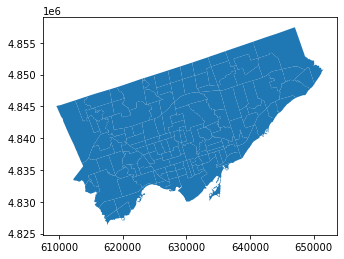

In [106]:
nbhoods = read_data(f'{dist_folder}/nbhoods.geojson')
nbhoods.plot()

### ID Joins

Join neighbourhood level datasets by neighbourhood ID.

In [107]:
to_join = [
    'crime',
    'education',
    'environment',
    'demographics',
    'housing',
    'economics',
    'civics',
    'health'
]

for name in to_join:
    
    file = Path(f'{dist_folder}/by-dataset/geohoods_to_{name}.geojson')
    if not file.is_file() or force:
        
        # Start processing
        timer = Timer(name, 'join')
        timer.start()

        # Read and prepare data
        data = read_data(f'{dist_folder}/clean-datasets/{name}.geojson')
        data = data.drop('geometry', axis=1)

        # Add neighbourhood and remove from dataset
        if 'neighbourhood' in data:
            nbhoods['neighbourhood'] = data['neighbourhood']
            data = data.drop('neighbourhood', axis=1)

        # Join by nbhood id
        gdf = pd.merge(
            nbhoods,
            data,
            on='neighbourhood_id',
            how='left'
        )
        gdf = gdf.set_index('neighbourhood_id')

        # Save by dataset
        gdf.to_file(file)

        # Save by variable
        save_vars(gdf)

        # End processing
        timer.end()
        
    else:
        print(f'Skipped {name} - already joined ({datetime.now()})')

Processing crime - join (2022-02-11 23:28:26.782443)...
Processed crime - join (2022-02-11 23:28:27.624344) [Elapsed: 0:00:00.841899]
Processing education - join (2022-02-11 23:28:27.624583)...
Processed education - join (2022-02-11 23:28:28.000202) [Elapsed: 0:00:00.375617]
Processing environment - join (2022-02-11 23:28:28.000597)...
Processed environment - join (2022-02-11 23:28:28.374149) [Elapsed: 0:00:00.373551]
Processing demographics - join (2022-02-11 23:28:28.374404)...
Processed demographics - join (2022-02-11 23:28:28.788898) [Elapsed: 0:00:00.414493]
Processing housing - join (2022-02-11 23:28:28.789128)...
Processed housing - join (2022-02-11 23:28:29.166993) [Elapsed: 0:00:00.377859]
Processing economics - join (2022-02-11 23:28:29.167310)...
Processed economics - join (2022-02-11 23:28:29.577417) [Elapsed: 0:00:00.410105]
Processing civics - join (2022-02-11 23:28:29.577665)...
Processed civics - join (2022-02-11 23:28:29.984724) [Elapsed: 0:00:00.407057]
Processing hea

Preview results of id joins:

In [108]:
gdf = read_data(f'{dist_folder}/by-dataset/geohoods_to_demographics.geojson')
gdf

,neighbourhood_id,neighbourhood,demographics_pop2016_2008,demographics_pop2011_2008,demographics_popchg11t16_2008,demographics_0_to_04_years_2016,demographics_0_to_14_years_2016,demographics_05_to_09_years_2016,demographics_10_to_14_years_2016,demographics_100_years_and_over_2016,...,demographics_65_years_and_over_2016,demographics_70_to_74_years_2016,demographics_75_to_79_years_2016,demographics_80_to_84_years_2016,demographics_85_to_89_years_2016,demographics_85_years_and_over_2016,demographics_90_to_94_years_2016,demographics_95_to_99_years_2016,demographics_all_ages_2016,geometry
0,96,Long Branch,10968,10487,0.045866,355.0,1200.0,400.0,445.0,0.0,...,2675.0,665.0,470.0,305.0,255.0,395.0,100.0,35.0,10965.0,"POLYGON ((627795.397 4836876.867, 627781.902 4..."
1,95,New Toronto,30526,29177,0.046235,925.0,2360.0,760.0,675.0,20.0,...,5910.0,1335.0,1030.0,750.0,570.0,1040.0,340.0,110.0,30530.0,"POLYGON ((629463.304 4836332.300, 629324.313 4..."
2,109,Alderwood,9955,9851,0.010557,505.0,1490.0,500.0,490.0,0.0,...,1325.0,320.0,240.0,175.0,105.0,165.0,45.0,10.0,9955.0,"POLYGON ((624110.361 4837657.166, 624091.125 4..."
3,64,Mimico (includes Humber Bay Shores),12541,11703,0.071606,905.0,2325.0,820.0,600.0,0.0,...,1380.0,310.0,225.0,165.0,125.0,170.0,45.0,5.0,12540.0,"POLYGON ((635860.212 4836239.139, 635719.852 4..."
4,103,Islington-City Centre West,15179,15070,0.007233,675.0,2845.0,990.0,1175.0,0.0,...,2235.0,560.0,335.0,275.0,205.0,315.0,100.0,20.0,15170.0,"POLYGON ((628032.302 4840233.689, 627977.197 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,126,Malvern,25003,24363,0.026269,1365.0,4250.0,1470.0,1415.0,5.0,...,3780.0,735.0,590.0,570.0,440.0,790.0,265.0,75.0,25000.0,"POLYGON ((637264.757 4848044.207, 637331.396 4..."
136,133,Agincourt North,13362,13093,0.020545,655.0,2150.0,720.0,780.0,5.0,...,2385.0,665.0,475.0,240.0,115.0,160.0,35.0,10.0,13365.0,"POLYGON ((649297.450 4847596.814, 649298.794 4..."
137,22,Steeles,15545,15853,-0.019428,995.0,2945.0,1035.0,920.0,0.0,...,2160.0,440.0,455.0,320.0,180.0,260.0,70.0,10.0,15545.0,"POLYGON ((618676.633 4843651.507, 618660.054 4..."
138,37,Rouge,16936,15004,0.128766,695.0,1785.0,600.0,500.0,10.0,...,3370.0,665.0,600.0,525.0,405.0,655.0,205.0,40.0,16935.0,"POLYGON ((625533.338 4846776.345, 625525.472 4..."


### Spatial Binning (Counts Only)

Spatially bin counted column values into each neighbourhood using the cleaned datasets.

In [109]:
to_count = [
    'autospeed_enforcement',
    'red_light_cams',
    'police',
    'ambulance',
    'fire_hydrants',
    'fire_stations',
    'renewables',
    'bicycle_parking',
    'transit_shelters',
    'wayfind',
    'litter',
    'art',
    'culture',
    'religious'
]
for name in to_count:
    
    # Read data
    data = read_data(f'{dist_folder}/clean-datasets/{name}.geojson')

    # Only process if dataset file not created
    file = Path(f'{dist_folder}/by-dataset/geohoods_to_{name}.geojson')
    if not file.is_file() or force:

        # Start processing
        timer = Timer(name, 'spatial binning')
        timer.start()

        # Spatial join to grid
        join = nbhoods.sjoin(data, predicate='intersects')

        # Agg counts
        counts = join.groupby(join.index).size()
        counts_col = f'{name}_count'
        counts.name = counts_col

        # Add counts to nbhoods
        gdf = nbhoods.join(counts)
        gdf[counts_col] = gdf[counts_col].fillna(0)

        # Save by dataset
        gdf.to_file(file)

        # Save by variable
        save_vars(gdf)

        # End processing
        timer.end()

    else:
        print(f'Skipping {file} - already binned ({datetime.now()})')

Processing autospeed_enforcement - spatial binning (2022-02-11 23:28:30.573250)...


/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed autospeed_enforcement - spatial binning (2022-02-11 23:28:30.808456) [Elapsed: 0:00:00.235203]
Processing red_light_cams - spatial binning (2022-02-11 23:28:30.817622)...


/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed red_light_cams - spatial binning (2022-02-11 23:28:31.060858) [Elapsed: 0:00:00.243235]
Processing police - spatial binning (2022-02-11 23:28:31.066193)...


/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed police - spatial binning (2022-02-11 23:28:31.287212) [Elapsed: 0:00:00.221019]
Processing ambulance - spatial binning (2022-02-11 23:28:31.292803)...


/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed ambulance - spatial binning (2022-02-11 23:28:31.515338) [Elapsed: 0:00:00.222535]
Processing fire_hydrants - spatial binning (2022-02-11 23:28:32.358445)...


/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed fire_hydrants - spatial binning (2022-02-11 23:28:32.614297) [Elapsed: 0:00:00.255853]
Processing fire_stations - spatial binning (2022-02-11 23:28:32.629766)...


/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed fire_stations - spatial binning (2022-02-11 23:28:32.853871) [Elapsed: 0:00:00.224106]
Processing renewables - spatial binning (2022-02-11 23:28:32.860476)...


/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed renewables - spatial binning (2022-02-11 23:28:33.084016) [Elapsed: 0:00:00.223539]
Processing bicycle_parking - spatial binning (2022-02-11 23:28:33.439531)...


/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed bicycle_parking - spatial binning (2022-02-11 23:28:33.682777) [Elapsed: 0:00:00.243246]
Processing transit_shelters - spatial binning (2022-02-11 23:28:33.809930)...


/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed transit_shelters - spatial binning (2022-02-11 23:28:34.041995) [Elapsed: 0:00:00.232065]
Processing wayfind - spatial binning (2022-02-11 23:28:34.055039)...


/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed wayfind - spatial binning (2022-02-11 23:28:34.280230) [Elapsed: 0:00:00.225191]
Processing litter - spatial binning (2022-02-11 23:28:34.490746)...


/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed litter - spatial binning (2022-02-11 23:28:34.725338) [Elapsed: 0:00:00.234591]
Processing art - spatial binning (2022-02-11 23:28:34.740821)...


/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed art - spatial binning (2022-02-11 23:28:34.967001) [Elapsed: 0:00:00.226178]
Processing culture - spatial binning (2022-02-11 23:28:34.990879)...


/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed culture - spatial binning (2022-02-11 23:28:35.221843) [Elapsed: 0:00:00.230965]
Processing religious - spatial binning (2022-02-11 23:28:35.255974)...


/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed religious - spatial binning (2022-02-11 23:28:35.480071) [Elapsed: 0:00:00.224097]


Preview a spatially binned count dataset:

In [110]:
preview = gpd.read_file(f'{dist_folder}/by-dataset/geohoods_to_autospeed_enforcement.geojson')
preview

,neighbourhood_id,neighbourhood,autospeed_enforcement_count,geometry
0,96,Long Branch,0.0,"POLYGON ((627795.397 4836876.867, 627781.902 4..."
1,95,New Toronto,1.0,"POLYGON ((629463.304 4836332.300, 629324.313 4..."
2,109,Alderwood,1.0,"POLYGON ((624110.361 4837657.166, 624091.125 4..."
3,64,Mimico,0.0,"POLYGON ((635860.212 4836239.139, 635719.852 4..."
4,103,Islington-City Centre West,0.0,"POLYGON ((628032.302 4840233.689, 627977.197 4..."
...,...,...,...,...
135,126,Malvern,1.0,"POLYGON ((637264.757 4848044.207, 637331.396 4..."
136,133,Agincourt North,0.0,"POLYGON ((649297.450 4847596.814, 649298.794 4..."
137,22,Steeles,1.0,"POLYGON ((618676.633 4843651.507, 618660.054 4..."
138,37,Rouge,2.0,"POLYGON ((625533.338 4846776.345, 625525.472 4..."


<AxesSubplot:>

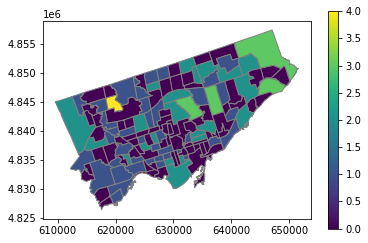

In [111]:
preview.plot(
    column='autospeed_enforcement_count',
    edgecolor='gray',
    legend=True
)

### Spatial Binning (Aggregates)

Spatially bin aggregate column values into each neighbourhood using the cleaned datasets.

#### centrelines

Bin centreline geometry calculations and features:

In [112]:
name = 'centrelines'
data = read_data(f'{dist_folder}/clean-datasets/{name}.geojson')
force = True
# Only process if dataset file not created
file = Path(f'{dist_folder}/by-dataset/geohoods_to_{name}.geojson')
if not file.is_file() or force:

    # Start processing
    timer = Timer(name, 'spatial binning')
    timer.start()

    # Split lines at polygons using overlay
    overlay = gpd.overlay(
        data,
        nbhoods,
        how='intersection'
    ).explode(index_parts=False)

    # Add sinuosity metric (how curved lines are)
    overlay.insert(
        len(overlay.columns) - 2, # insert before geometry
        'sin',
        lsin(overlay.geometry)
    )

    # Spatial join lines to each nbhood
    join = overlay.sjoin(nbhoods, predicate='intersects')

    # Aggregate cols by nbhood
    agg = join.groupby(join['index_right']).agg({
        'centrelines_feature_code': [mode],
        'centrelines_oneway_dir_code': [mode],
        'geometry': [
            ('len_sum', glen('sum')),
            ('len_mean', glen('mean')),
            ('len_median', glen('median')),
            ('len_min', glen('min')),
            ('len_max', glen('max'))
        ],
        'sin': genstats
    })
    
    # Rename agg cols
    agg.columns = ['_'.join(c).strip().replace('geometry_', '') for c in agg.columns]
    agg.columns = [f'centrelines_{c}' if not c.startswith('centrelines_') else c for c in agg.columns]
    
    # Count freq
    freq = []
    for c in ['centrelines_feature_code', 'centrelines_oneway_dir_code']:
        
        # Get possible unique values in col
        possible = data[c].unique()
        
        # Count freq for each unique value
        f = join.groupby(join['index_right']).apply(ucounts, c=c, possible=possible)
        
        # Rename freq cols
        f = format_cols(f)
        prefix = c.replace(f'{name}_', '')
        f.columns = [f'centrelines_{prefix}_{c}_count' for c in f.columns]
        freq.append(f)
    
    # Combine count freq
    freq = pd.concat(freq, axis=1)
    freq.index = freq.index.get_level_values('index_right')

    # Add agg and freq to nbhoods
    gdf = nbhoods.join(agg)
    gdf = gdf.join(freq)

    # Save by dataset
    gdf.to_file(file)

    # Save by variable
    save_vars(gdf)

    # End processing
    timer.end()

else:
    print(f'Skipping {file} - already binned ({datetime.now()})')

Processing centrelines - spatial binning (2022-02-11 23:28:38.711458)...


/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed centrelines - spatial binning (2022-02-11 23:28:52.758704) [Elapsed: 0:00:14.047246]


Preview results of spatial binning `centrelines`:

In [113]:
preview = gpd.read_file(f'{dist_folder}/by-dataset/geohoods_to_centrelines.geojson')
preview

,neighbourhood_id,neighbourhood,centrelines_feature_code_mode,centrelines_oneway_dir_code_mode,centrelines_len_sum,centrelines_len_mean,centrelines_len_median,centrelines_len_min,centrelines_len_max,centrelines_sin_sum,...,centrelines_feature_code_collector_ramp_count,centrelines_feature_code_minor_arterial_ramp_count,centrelines_feature_code_minor_railway_count,centrelines_feature_code_other_ramp_count,centrelines_feature_code_busway_count,centrelines_feature_code_creektributary_count,centrelines_oneway_dir_code_not_oneway_count,centrelines_oneway_dir_code_againstdigitization_count,centrelines_oneway_dir_code_followdigitization_count,geometry
0,96,Long Branch,Local,Not One-Way,35051.442648,81.137599,53.692545,3.053540e-07,566.490593,4.612397e+02,...,0,0,0,0,0,0,390,17,25,"POLYGON ((627795.397 4836876.867, 627781.902 4..."
1,95,New Toronto,Local,Not One-Way,56682.797135,70.676804,50.433971,5.388018e-08,371.531523,8.176592e+02,...,0,0,0,0,0,0,648,78,76,"POLYGON ((629463.304 4836332.300, 629324.313 4..."
2,109,Alderwood,Local,Not One-Way,29269.318647,70.358939,51.057950,5.534725e-08,687.716232,4.414906e+02,...,0,0,0,0,0,0,377,16,23,"POLYGON ((624110.361 4837657.166, 624091.125 4..."
3,64,Mimico,Local,Not One-Way,28677.530209,72.418006,61.771523,3.140699e-07,716.821208,4.263399e+02,...,0,0,0,0,0,0,389,7,0,"POLYGON ((635860.212 4836239.139, 635719.852 4..."
4,103,Islington-City Centre West,Local,Not One-Way,51390.629974,90.956867,62.125844,1.794472e-07,494.744502,6.024772e+02,...,0,0,0,0,0,0,558,1,6,"POLYGON ((628032.302 4840233.689, 627977.197 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,126,Malvern,Local,Not One-Way,76548.683393,126.317959,92.400608,3.671919e-07,1522.464650,6.127808e+02,...,0,0,0,0,0,0,573,9,24,"POLYGON ((637264.757 4848044.207, 637331.396 4..."
136,133,Agincourt North,Local,Not One-Way,83447.795992,100.539513,51.111622,1.442228e-07,1010.397879,NaN,...,3,0,0,0,0,0,757,25,48,"POLYGON ((649297.450 4847596.814, 649298.794 4..."
137,22,Steeles,Local,Not One-Way,48156.722725,105.375761,60.938086,6.060086e-08,1363.843161,4.667883e+02,...,0,0,0,0,0,0,442,6,9,"POLYGON ((618676.633 4843651.507, 618660.054 4..."
138,37,Rouge,Local,Not One-Way,44449.734692,92.411091,70.146460,8.175638e-09,794.301394,1.571978e+08,...,0,0,0,0,0,0,481,0,0,"POLYGON ((625533.338 4846776.345, 625525.472 4..."


<AxesSubplot:>

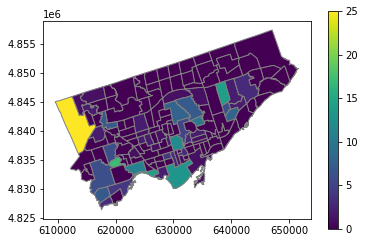

In [114]:
preview.plot(
    column='centrelines_feature_code_major_arterial_ramp_count',
    edgecolor='gray',
    legend=True
)

#### collisions

Bin collision features and counts:

In [115]:
name = 'collisions'
data = read_data(f'{dist_folder}/clean-datasets/{name}.geojson')
    
# Only process if dataset file not created
file = Path(f'{dist_folder}/by-dataset/geohoods_to_{name}.geojson')
if not file.is_file() or force:

    # Start processing
    timer = Timer(name, 'spatial binning')
    timer.start()
    
    # Spatial join to nbhood
    join = nbhoods.sjoin(data, predicate='intersects')

    # Agg cols by nbhood
    group = join.groupby(join.index)
    dtstats = [s for s in genstats if s != 'sum']
    agg = group.agg({
        'collisions_month': [mode],
        'collisions_day_of_month': [mode] + dtstats,
        'collisions_day_of_week': [mode],
        'collisions_year': [mode] + dtstats,
        'collisions_hour': [mode] + dtstats,
        'collisions_fatalities': genstats,
        'collisions_injury': genstats,
        'collisions_ftr': genstats,
        'collisions_pd': genstats,
    })
    
    # Rename agg cols
    agg.columns = ['_'.join(c).strip() for c in agg.columns]
    
    # Count freq
    freq = []
    for c in ['collisions_month', 'collisions_day_of_month', 'collisions_day_of_week', 'collisions_year', 'collisions_hour']:
        
        # Get possible unique values in col
        if c == 'collisions_month':
            possible = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
        elif c == 'collisions_day_of_month':
            possible = [*range(1,32)]
        elif c == 'collisions_day_of_week':
            possible = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        elif c == 'collisions_hour':
            possible = [*range(0,24)]
        else:
            possible = data[c].unique()
        
        # Count freq for each unique value
        f = join.groupby(join['index_right']).apply(ucounts, c=c, possible=possible)
        
        # Rename freq cols
        f = format_cols(f)
        prefix = c.replace(f'{name}_', '')
        f.columns = [f'collisions_{prefix}_{c}_count' for c in f.columns]
        freq.append(f)
    
    # Combine count freq
    freq = pd.concat(freq, axis=1)
    freq.index = freq.index.get_level_values('index_right')
    
    # Agg counts
    counts = group.size()
    counts.name = 'collisions_count'

    # Add agg, freq, and counts to nbhoods
    gdf = nbhoods.join(agg)
    gdf = gdf.join(freq)
    gdf = gdf.join(counts)
    gdf['collisions_count'] = gdf['collisions_count'].fillna(0)

    # Save by dataset
    gdf.to_file(file)

    # Save by variable
    save_vars(gdf)

    # End processing
    timer.end()

else:
    print(f'Skipping {file} - already binned ({datetime.now()})')

Processing collisions - spatial binning (2022-02-11 23:29:09.287377)...


/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed collisions - spatial binning (2022-02-11 23:54:15.520040) [Elapsed: 0:25:06.232662]


Preview results of spatial binning `collisions`:

In [116]:
preview = gpd.read_file(f'{dist_folder}/by-dataset/geohoods_to_collisions.geojson')
preview = preview[preview['collisions_fatalities_mean'] > 0]
preview

,neighbourhood_id,neighbourhood,collisions_month_mode,collisions_day_of_month_mode,collisions_day_of_month_mean,collisions_day_of_month_min,collisions_day_of_month_max,collisions_day_of_month_median,collisions_day_of_month_var,collisions_day_of_month_skew,...,collisions_hour_16_count,collisions_hour_17_count,collisions_hour_18_count,collisions_hour_19_count,collisions_hour_20_count,collisions_hour_21_count,collisions_hour_22_count,collisions_hour_23_count,collisions_count,geometry
1,95,New Toronto,June,13,15.654795,1,31,15.0,77.810014,0.047411,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4380,"POLYGON ((629463.304 4836332.300, 629324.313 4..."
2,109,Alderwood,June,3,15.305447,1,31,15.0,76.666105,0.087921,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1028,"POLYGON ((624110.361 4837657.166, 624091.125 4..."
4,103,Islington-City Centre West,November,17,15.597163,1,31,16.0,76.204722,0.043858,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2115,"POLYGON ((628032.302 4840233.689, 627977.197 4..."
5,130,Markland Wood,January,2,15.622478,1,31,16.0,77.615771,0.014517,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6344,"POLYGON ((641302.472 4852600.387, 641202.087 4..."
7,26,Etobicoke West Mall,June,18,15.527235,1,31,15.0,78.801776,0.043512,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7270,"POLYGON ((620199.686 4841607.150, 620142.908 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,126,Malvern,January,10,15.859771,1,31,16.0,77.724418,-0.014282,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6468,"POLYGON ((637264.757 4848044.207, 637331.396 4..."
136,133,Agincourt North,November,5,15.602081,1,31,15.0,75.159162,0.032884,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,769,"POLYGON ((649297.450 4847596.814, 649298.794 4..."
137,22,Steeles,June,24,15.842645,1,31,16.0,76.322538,-0.019580,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3508,"POLYGON ((618676.633 4843651.507, 618660.054 4..."
138,37,Rouge,January,10,15.985240,1,31,16.0,77.186244,-0.030662,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1626,"POLYGON ((625533.338 4846776.345, 625525.472 4..."


<AxesSubplot:>

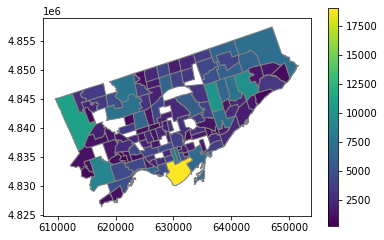

In [117]:
preview.plot(
    column='collisions_count',
    edgecolor='gray',
    legend=True
)

#### traffic

Bin counts of traffic features and counts:

In [118]:
name = 'traffic'
data = read_data(f'{dist_folder}/clean-datasets/{name}.geojson')
    
# Only process if dataset file not created
file = Path(f'{dist_folder}/by-dataset/geohoods_to_{name}.geojson')
if not file.is_file() or force:

    # Start processing
    timer = Timer(name, 'spatial binning')
    timer.start()
    
    # Spatial join to nbhood
    join = nbhoods.sjoin(data, predicate='intersects')

    # Agg cols by nbhood
    group = join.groupby(join.index)
    agg = group.agg({
        c: genstats for c in data.columns if c not in ['geometry', 'traffic_month', 'traffic_day_of_month', 'traffic_year']
    })
    
    # Rename agg cols
    agg.columns = ['_'.join(c).strip() for c in agg.columns]
    
    # Count freq
    freq = []
    for c in ['traffic_month', 'traffic_day_of_month', 'traffic_year']:
        
        # Get possible unique values in col
        if c == 'traffic_month':
            possible = [*range(1,32)]
        elif c == 'traffic_day_of_month':
            possible = [*range(1,32)]
        else:
            possible = data[c].unique()
        
        # Count freq for each unique value
        f = join.groupby(join['index_right']).apply(ucounts, c=c, possible=possible)
        
        # Rename freq cols
        f = format_cols(f)
        prefix = c.replace(f'{name}_', '')
        f.columns = [f'traffic_{prefix}_{c}_count' for c in f.columns]
        freq.append(f)
        
    # Combine count freq
    freq = pd.concat(freq, axis=1)
    freq.index = freq.index.get_level_values('index_right')
    
    # Agg counts
    counts = group.size()
    counts.name = 'traffic_count'

    # Add agg, freq, and counts to nbhoods
    gdf = nbhoods.join(agg)
    gdf = gdf.join(freq)
    gdf = gdf.join(counts)
    gdf['traffic_count'] = gdf['traffic_count'].fillna(0)

    # Save by dataset
    gdf.to_file(file)

    # Save by variable
    save_vars(gdf)

    # End processing
    timer.end()

else:
    print(f'Skipping {file} - already binned ({datetime.now()})')

Processing traffic - spatial binning (2022-02-11 23:54:45.182175)...


/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed traffic - spatial binning (2022-02-12 00:04:02.795829) [Elapsed: 0:09:17.613653]


Preview results of spatial binning `traffic`:

In [119]:
preview = gpd.read_file(f'{dist_folder}/by-dataset/geohoods_to_traffic.geojson')
preview = preview[preview['traffic_nb_cars_t_mean'] >= 0]
preview

,neighbourhood_id,neighbourhood,traffic_sb_cars_r_sum,traffic_sb_cars_r_mean,traffic_sb_cars_r_min,traffic_sb_cars_r_max,traffic_sb_cars_r_median,traffic_sb_cars_r_var,traffic_sb_cars_r_skew,traffic_sb_cars_r_std,...,traffic_year_2016_count,traffic_year_2010_count,traffic_year_2013_count,traffic_year_2019_count,traffic_year_2017_count,traffic_year_2014_count,traffic_year_2011_count,traffic_year_2018_count,traffic_count,geometry
0,96,Long Branch,16962.0,10.522333,0.0,75.0,5.0,151.784107,1.258131,12.320069,...,0,0,0,0,0,0,0,0,1612,"POLYGON ((627795.397 4836876.867, 627781.902 4..."
1,95,New Toronto,23439.0,6.930514,0.0,75.0,2.0,115.144830,2.355753,10.730556,...,0,0,0,0,0,0,0,0,3382,"POLYGON ((629463.304 4836332.300, 629324.313 4..."
2,109,Alderwood,5938.0,6.627232,0.0,45.0,4.0,70.205023,1.989757,8.378844,...,0,0,0,0,0,0,0,0,896,"POLYGON ((624110.361 4837657.166, 624091.125 4..."
3,64,Mimico,10841.0,10.586914,0.0,79.0,7.0,154.612184,1.695867,12.434315,...,0,0,0,0,0,0,0,0,1024,"POLYGON ((635860.212 4836239.139, 635719.852 4..."
4,103,Islington-City Centre West,9095.0,6.128706,0.0,64.0,4.0,63.812823,2.665686,7.988293,...,0,0,0,0,0,0,0,0,1484,"POLYGON ((628032.302 4840233.689, 627977.197 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,126,Malvern,36593.0,22.870625,0.0,222.0,15.0,688.175247,2.278067,26.233094,...,1,0,0,0,0,0,0,0,1600,"POLYGON ((637264.757 4848044.207, 637331.396 4..."
136,133,Agincourt North,12437.0,13.401940,0.0,74.0,9.0,202.788648,1.492772,14.240388,...,1,0,0,0,0,0,0,0,928,"POLYGON ((649297.450 4847596.814, 649298.794 4..."
137,22,Steeles,15026.0,19.565104,0.0,242.0,6.0,1470.068768,3.175142,38.341476,...,1,0,0,0,0,0,0,0,768,"POLYGON ((618676.633 4843651.507, 618660.054 4..."
138,37,Rouge,17450.0,14.738176,0.0,119.0,3.0,679.485067,2.191072,26.066934,...,1,0,0,0,0,0,0,0,1184,"POLYGON ((625533.338 4846776.345, 625525.472 4..."


<AxesSubplot:>

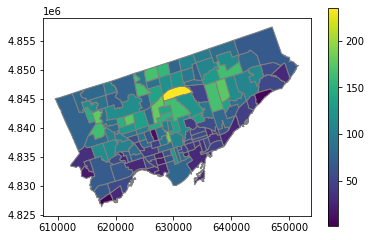

In [120]:
preview.plot(
    column='traffic_nb_cars_t_mean',
    edgecolor='gray',
    legend=True
)

#### watch_your_speed

Bin watch your speed program location counts and features:

In [121]:
name = 'watch_your_speed'
data = read_data(f'{dist_folder}/clean-datasets/{name}.geojson')
    
# Only process if dataset file not created
file = Path(f'{dist_folder}/by-dataset/geohoods_to_{name}.geojson')
if not file.is_file() or force:

    # Start processing
    timer = Timer(name, 'spatial binning')
    timer.start()
    
    # Spatial join to nbhood
    join = nbhoods.sjoin(data, predicate='intersects')

    # Agg cols by nbhood
    group = join.groupby(join.index)
    agg = group.agg({
        'wys_dir': [mode],
        'wys_min_speed': [mode] + genstats,
        'wys_speed_limit': [mode] + genstats,
    })
    
    # Rename agg cols
    agg.columns = ['_'.join(c).strip() for c in agg.columns]
    
    # Count freq
    freq = []
    for c in ['wys_dir', 'wys_min_speed', 'wys_speed_limit']:
        
        # Get possible unique values in col
        possible = data[c].unique()
        
        # Count freq for each unique value
        f = join.groupby(join['index_right']).apply(ucounts, c=c, possible=possible)
        
        # Rename freq cols
        f = format_cols(f)
        prefix = c.replace(f'wys_', '')
        f.columns = [f'wys_{prefix}_{c}_count' for c in f.columns]
        freq.append(f)
        
    # Combine count freq
    freq = pd.concat(freq, axis=1)
    freq.index = freq.index.get_level_values('index_right')
    
    # Agg counts
    counts = group.size()
    counts.name = 'wys_count'

    # Add agg, freq, and counts to nbhoods
    gdf = nbhoods.join(agg)
    gdf = gdf.join(freq)
    gdf = gdf.join(counts)
    gdf['wys_count'] = gdf['wys_count'].fillna(0)

    # Save by dataset
    gdf.to_file(file)

    # Save by variable
    save_vars(gdf)

    # End processing
    timer.end()

else:
    print(f'Skipping {file} - already binned ({datetime.now()})')

Processing watch_your_speed - spatial binning (2022-02-12 00:04:03.706445)...


/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed watch_your_speed - spatial binning (2022-02-12 00:04:05.448283) [Elapsed: 0:00:01.741838]


Preview results of spatial binning `watch_your_speed`:

In [122]:
preview = gpd.read_file(f'{dist_folder}/by-dataset/geohoods_to_watch_your_speed.geojson')
preview = preview[preview['wys_count'] > 0]
preview

,neighbourhood_id,neighbourhood,wys_dir_mode,wys_min_speed_mode,wys_min_speed_sum,wys_min_speed_mean,wys_min_speed_min,wys_min_speed_max,wys_min_speed_median,wys_min_speed_var,...,wys_dir_none_count,wys_min_speed_5_count,wys_min_speed_30_count,wys_min_speed_20_count,wys_speed_limit_40_count,wys_speed_limit_50_count,wys_speed_limit_30_count,wys_speed_limit_60_count,wys_count,geometry
1,95,New Toronto,NB,20,100.0,20.000000,20.0,20.0,20.0,0.000000,...,0,0,1,0,0,1,0,0,5.0,"POLYGON ((629463.304 4836332.300, 629324.313 4..."
2,109,Alderwood,SB,30,100.0,20.000000,5.0,30.0,30.0,187.500000,...,0,0,1,0,0,1,0,0,5.0,"POLYGON ((624110.361 4837657.166, 624091.125 4..."
3,64,Mimico,NB,5,85.0,14.166667,5.0,30.0,12.5,114.166667,...,0,0,1,0,0,1,0,0,6.0,"POLYGON ((635860.212 4836239.139, 635719.852 4..."
4,103,Islington-City Centre West,EB,5,35.0,8.750000,5.0,20.0,5.0,56.250000,...,0,0,0,1,0,0,1,0,4.0,"POLYGON ((628032.302 4840233.689, 627977.197 4..."
5,130,Markland Wood,SB,5,20.0,5.000000,5.0,5.0,5.0,0.000000,...,0,0,0,1,0,0,1,0,4.0,"POLYGON ((641302.472 4852600.387, 641202.087 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,94,Bayview Woods-Steeles,EB,20,55.0,18.333333,5.0,30.0,20.0,158.333333,...,0,1,0,0,1,0,0,0,3.0,"POLYGON ((626071.503 4837537.756, 626151.708 4..."
134,97,Hillcrest Village,NB,5,5.0,5.000000,5.0,5.0,5.0,NaN,...,0,0,0,1,0,0,1,0,1.0,"POLYGON ((629674.232 4837709.743, 629657.497 4..."
137,22,Steeles,SB,30,140.0,28.000000,20.0,30.0,30.0,20.000000,...,0,1,0,0,1,0,0,0,5.0,"POLYGON ((618676.633 4843651.507, 618660.054 4..."
138,37,Rouge,WB,30,225.0,25.000000,5.0,30.0,30.0,75.000000,...,0,0,1,0,1,0,0,0,9.0,"POLYGON ((625533.338 4846776.345, 625525.472 4..."


<AxesSubplot:>

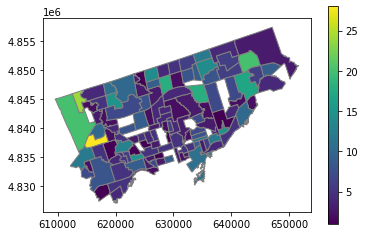

In [123]:
preview.plot(
    column='wys_count',
    edgecolor='gray',
    legend=True
)

#### schools

Bin school location counts and features:

In [124]:
name = 'schools'
data = read_data(f'{dist_folder}/clean-datasets/{name}.geojson')
    
# Only process if dataset file not created
file = Path(f'{dist_folder}/by-dataset/geohoods_to_{name}.geojson')
if not file.is_file() or force:

    # Start processing
    timer = Timer(name, 'spatial binning')
    timer.start()
    
    # Spatial join to nbhood
    join = nbhoods.sjoin(data, predicate='intersects')

    # Agg cols by nbhood
    group = join.groupby(join.index)
    agg = group.agg({
        'schools_level': [mode],
        'schools_type': [mode]
    })
    
    # Rename agg cols
    agg.columns = ['_'.join(c).strip() for c in agg.columns]
    
    # Count freq
    freq = []
    for c in ['schools_level', 'schools_type']:
        
        # Get possible unique values in col
        possible = data[c].unique()
        
        # Count freq for each unique value
        f = join.groupby(join['index_right']).apply(ucounts, c=c, possible=possible)
        
        # Rename freq cols
        f = format_cols(f)
        prefix = c.replace(f'{name}_', '')
        f.columns = [f'schools_{prefix}_{c}_count' for c in f.columns]
        freq.append(f)
        
    # Combine count freq
    freq = pd.concat(freq, axis=1)
    freq.index = freq.index.get_level_values('index_right')
    
    # Agg counts
    counts = group.size()
    counts.name = 'schools_count'

    # Add agg, freq, and counts to nbhoods
    gdf = nbhoods.join(agg)
    gdf = gdf.join(freq)
    gdf = gdf.join(counts)
    gdf['schools_count'] = gdf['schools_count'].fillna(0)

    # Save by dataset
    gdf.to_file(file)

    # Save by variable
    save_vars(gdf)

    # End processing
    timer.end()

else:
    print(f'Skipping {file} - already binned ({datetime.now()})')

Processing schools - spatial binning (2022-02-12 00:04:05.815964)...


/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed schools - spatial binning (2022-02-12 00:04:07.340116) [Elapsed: 0:00:01.524151]


Preview results of spatial binning `watch_your_speed`:

In [125]:
preview = gpd.read_file(f'{dist_folder}/by-dataset/geohoods_to_schools.geojson')
preview = preview[preview['schools_count'] > 0]
preview

,neighbourhood_id,neighbourhood,schools_level_mode,schools_type_mode,schools_level_none_count,schools_type_private_count,schools_type_english_public_count,schools_type_english_separate_count,schools_type_none_count,schools_type_french_public_count,schools_type_french_separate_count,schools_type_university_count,schools_count,geometry
0,96,Long Branch,None,Private,0,1,0,0,0,0,0,0,7.0,"POLYGON ((627795.397 4836876.867, 627781.902 4..."
1,95,New Toronto,None,Private,0,0,1,0,0,0,0,0,14.0,"POLYGON ((629463.304 4836332.300, 629324.313 4..."
2,109,Alderwood,None,English Separate,0,0,0,1,0,0,0,0,5.0,"POLYGON ((624110.361 4837657.166, 624091.125 4..."
3,64,Mimico,None,English Public,0,0,0,0,0,0,0,0,3.0,"POLYGON ((635860.212 4836239.139, 635719.852 4..."
4,103,Islington-City Centre West,None,English Public,0,0,0,1,0,0,0,0,7.0,"POLYGON ((628032.302 4840233.689, 627977.197 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,126,Malvern,None,English Public,0,1,0,0,0,0,0,0,8.0,"POLYGON ((637264.757 4848044.207, 637331.396 4..."
136,133,Agincourt North,None,English Public,0,1,0,0,0,0,0,0,5.0,"POLYGON ((649297.450 4847596.814, 649298.794 4..."
137,22,Steeles,None,English Public,0,0,0,1,0,0,0,0,8.0,"POLYGON ((618676.633 4843651.507, 618660.054 4..."
138,37,Rouge,None,Private,0,0,1,0,0,0,0,0,8.0,"POLYGON ((625533.338 4846776.345, 625525.472 4..."


<AxesSubplot:>

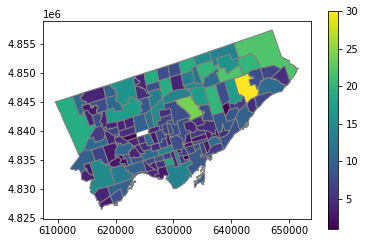

In [126]:
preview.plot(
    column='schools_count',
    edgecolor='gray',
    legend=True
)

#### childcare

Bin childcare location counts and features:

In [127]:
name = 'childcare'
data = read_data(f'{dist_folder}/clean-datasets/{name}.geojson')
    
# Only process if dataset file not created
file = Path(f'{dist_folder}/by-dataset/geohoods_to_{name}.geojson')
if not file.is_file() or force:

    # Start processing
    timer = Timer(name, 'spatial binning')
    timer.start()
    
    # Spatial join to nbhood
    join = nbhoods.sjoin(data, predicate='intersects')

    # Agg cols by nbhood
    group = join.groupby(join.index)
    agg = group.agg({
        'childcare_auspice': [mode],
        'childcare_bldg_type': [mode],
        'childcare_igspace': genstats,
        'childcare_tgspace': genstats,
        'childcare_pgspace': genstats,
        'childcare_kgspace': genstats,
        'childcare_sgspace': genstats,
        'childcare_totspace': genstats,
        'childcare_subsidy': genstats
    })
    
    # Rename agg cols
    agg.columns = ['_'.join(c).strip() for c in agg.columns]
    
    # Count freq
    freq = []
    for c in ['childcare_auspice', 'childcare_bldg_type']:
        
        # Get possible unique values in col
        possible = data[c].unique()
        
        # Count freq for each unique value
        f = join.groupby(join['index_right']).apply(ucounts, c=c, possible=possible)
        
        # Rename freq cols
        f = format_cols(f)
        prefix = c.replace(f'{name}_', '')
        f.columns = [f'childcare_{prefix}_{c}_count' for c in f.columns]
        freq.append(f)
        
    # Combine count freq
    freq = pd.concat(freq, axis=1)
    freq.index = freq.index.get_level_values('index_right')
    
    # Agg counts
    counts = group.size()
    counts.name = 'childcare_count'

    # Add agg, freq, and counts to nbhoods
    gdf = nbhoods.join(agg)
    gdf = gdf.join(freq)
    gdf = gdf.join(counts)
    gdf['childcare_count'] = gdf['childcare_count'].fillna(0)

    # Save by dataset
    gdf.to_file(file)

    # Save by variable
    save_vars(gdf)

    # End processing
    timer.end()

else:
    print(f'Skipping {file} - already binned ({datetime.now()})')

Processing childcare - spatial binning (2022-02-12 00:04:07.689063)...


/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed childcare - spatial binning (2022-02-12 00:04:10.895863) [Elapsed: 0:00:03.206799]


Preview results of spatial binning `watch_your_speed`:

In [128]:
preview = gpd.read_file(f'{dist_folder}/by-dataset/geohoods_to_childcare.geojson')
preview = preview[preview['childcare_count'] > 0]
preview

,neighbourhood_id,neighbourhood,childcare_auspice_mode,childcare_bldg_type_mode,childcare_igspace_sum,childcare_igspace_mean,childcare_igspace_min,childcare_igspace_max,childcare_igspace_median,childcare_igspace_var,...,childcare_bldg_type_multi_human_services_facility_count,childcare_bldg_type_low_rise_apartment_count,childcare_bldg_type_synagogue_count,childcare_bldg_type_private_elementary_school_count,childcare_bldg_type_communityrec_centre_aocc_count,childcare_bldg_type_communityrec_centre_private_count,childcare_bldg_type_hospitalhealth_centre_count,childcare_bldg_type_community_health_centre_count,childcare_count,geometry
0,96,Long Branch,Non Profit Agency,Other,10,2.000000,0,10,0.0,20.000000,...,0,0,0,0,0,0,0,0,5,"POLYGON ((627795.397 4836876.867, 627781.902 4..."
1,95,New Toronto,Non Profit Agency,Public Elementary School,10,1.000000,0,10,0.0,10.000000,...,0,0,0,0,0,0,0,0,10,"POLYGON ((629463.304 4836332.300, 629324.313 4..."
2,109,Alderwood,Non Profit Agency,Public Elementary School,10,5.000000,0,10,5.0,50.000000,...,0,0,0,0,0,0,0,0,2,"POLYGON ((624110.361 4837657.166, 624091.125 4..."
3,64,Mimico,Non Profit Agency,Public Elementary School,26,5.200000,0,10,6.0,25.200000,...,0,0,0,0,0,0,0,0,5,"POLYGON ((635860.212 4836239.139, 635719.852 4..."
4,103,Islington-City Centre West,Non Profit Agency,Public Elementary School,0,0.000000,0,0,0.0,0.000000,...,0,0,0,0,0,0,0,0,4,"POLYGON ((628032.302 4840233.689, 627977.197 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,126,Malvern,Commercial Agency,Place of Worship,10,2.500000,0,10,0.0,25.000000,...,0,0,0,0,0,0,0,0,4,"POLYGON ((637264.757 4848044.207, 637331.396 4..."
136,133,Agincourt North,Non Profit Agency,Public Elementary (French),6,1.200000,0,6,0.0,7.200000,...,0,0,0,0,0,0,0,0,5,"POLYGON ((649297.450 4847596.814, 649298.794 4..."
137,22,Steeles,Non Profit Agency,Public Elementary School,30,6.000000,0,10,10.0,30.000000,...,0,0,0,0,0,0,0,0,5,"POLYGON ((618676.633 4843651.507, 618660.054 4..."
138,37,Rouge,Non Profit Agency,Public Elementary School,40,6.666667,0,20,5.0,66.666667,...,0,0,0,0,0,0,0,0,6,"POLYGON ((625533.338 4846776.345, 625525.472 4..."


<AxesSubplot:>

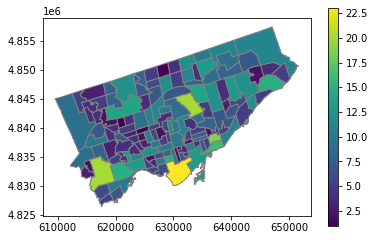

In [129]:
preview.plot(
    column='childcare_count',
    edgecolor='gray',
    legend=True
)

### Combine Datasets

Combine processed datasets into one final dataset.

In [130]:
# Get dataset files
dfiles = Path(f'{dist_folder}/by-dataset').glob('*')
dfiles = [f for f in dfiles if f.is_file() and f.suffix == '.geojson']

# Combine if not exists
file = Path(f'{dist_folder}/geohoods_to.geojson')
if not file.is_file() or force:
    
    # Read each file and combine to nbhoods
    out = read_data(f'{dist_folder}/nbhoods.geojson')
    for f in dfiles:
        
        # Start processing
        timer = Timer(str(f), 'combining')
        timer.start()
        
        # Read dataset and drop unneeded columns
        data = read_data(f).drop('geometry', axis=1)
        if 'neighbourhood' in data:
            data = data.drop('neighbourhood', axis=1)
        
        # Combine dataset
        out = pd.merge(
            out,
            data,
            on='neighbourhood_id',
            how='left'
        )
        
        # End processing
        timer.end()
    
    # Save combined datasets
    out.to_file(file)
    
else:
    print(f'Skipping {file} - already combined ({datetime.now()})')

Processing ../tmp/dist/by-dataset/geohoods_to_autospeed_enforcement.geojson - combining (2022-02-12 00:04:11.396159)...
Processed ../tmp/dist/by-dataset/geohoods_to_autospeed_enforcement.geojson - combining (2022-02-12 00:04:11.528421) [Elapsed: 0:00:00.132262]
Processing ../tmp/dist/by-dataset/geohoods_to_centrelines.geojson - combining (2022-02-12 00:04:11.528507)...
Processed ../tmp/dist/by-dataset/geohoods_to_centrelines.geojson - combining (2022-02-12 00:04:11.683352) [Elapsed: 0:00:00.154844]
Processing ../tmp/dist/by-dataset/geohoods_to_wayfind.geojson - combining (2022-02-12 00:04:11.683565)...
Processed ../tmp/dist/by-dataset/geohoods_to_wayfind.geojson - combining (2022-02-12 00:04:11.819142) [Elapsed: 0:00:00.135576]
Processing ../tmp/dist/by-dataset/geohoods_to_crime.geojson - combining (2022-02-12 00:04:11.819217)...
Processed ../tmp/dist/by-dataset/geohoods_to_crime.geojson - combining (2022-02-12 00:04:12.002740) [Elapsed: 0:00:00.183522]
Processing ../tmp/dist/by-datase

/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## Summary

In [131]:
gtimer.end()

Processed all datasets - preprocessing (2022-02-12 00:04:59.749982) [Elapsed: 0:36:33.230457]


Information for the final dataset `geohoods_to.geojson`:

In [132]:
geohoods_info = dict(file=f'{dist_folder}/geohoods_to.geojson')
geohoods_info = dict(geohoods_info, **df_info(out, 'geohoods_to'))
geohoods_info = dict(geohoods_info, **file_info(f'{dist_folder}/geohoods_to.geojson'))
for k, v in geohoods_info.items():
    print(f'{k}: {v}')

file: ../tmp/dist/geohoods_to.geojson
dataset: geohoods_to
columns: 1335
rows: 140
memory_usage: 1.4 MiB
geometry: ['Polygon']
created: 2022-02-12 00:04:15.953707
modified: 2022-02-12 00:04:59.747105
size: 9.0 MiB


The final dataset is also split by datasets for convenience:

In [133]:
# Get files and dataset names
sources = read_data(data_sources_file)
datasets = [Path(row.file).with_suffix('').stem for row in sources.itertuples() if Path(row.file).stem != study_area_dataset]
files = [f'{dist_folder}/by-dataset/geohoods_to_{name}.geojson' for name in datasets]

# Read datasets
datasets = {name: read_data(f'{dist_folder}/by-dataset/geohoods_to_{name}.geojson') for name in datasets}

# Create summary info
info = pd.DataFrame([df_info(df, name) for name, df in datasets.items()])
info_files = pd.DataFrame([file_info(name) for name in files])
summary = pd.concat([info, info_files], axis=1)

# Add supplymentary info
sources = sources.rename(columns={'file': 'dataset'})
sources = sources[sources['dataset'] != f'{study_area_dataset}.geojson']
sources['dataset'] = [k for k in datasets]
summary = pd.merge(
    summary,
    sources,
    on='dataset',
    how='left'
)
                    
# Rearrange summary columns and display
summary['file'] = files
summary = summary.rename(columns={'url': 'raw_url'})
summary = summary[['dataset', 'file', 'created', 'modified', 'columns', 'rows', 'geometry', 'memory_usage', 'size', 'source', 'source_url', 'raw_url']]
display(HTML(summary.to_html(render_links=True)))

,dataset,file,created,modified,columns,rows,geometry,memory_usage,size,source,source_url,raw_url
0,centrelines,../tmp/dist/by-dataset/geohoods_to_centrelines.geojson,2022-02-11 23:28:52.408449,2022-02-11 23:28:52.704899,52,140,['Polygon'],57.0 KiB,2.5 MiB,City of Toronto Open Data Portal,https://open.toronto.ca/dataset/toronto-centreline-tcl/,https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/ba71b78e-464b-46dd-8185-a0d249fe4857
1,collisions,../tmp/dist/by-dataset/geohoods_to_collisions.geojson,2022-02-11 23:54:14.286233,2022-02-11 23:54:15.395874,179,140,['Polygon'],195.9 KiB,3.1 MiB,Toronto Police Service Public Safety Data Portal,https://data.torontopolice.on.ca/datasets/TorontoPS::traffic-collisions-asr-t-tbl-001/about,https://opendata.arcgis.com/api/v3/datasets/2a36d61277a84c3eb9d0beebef4c023d_0/downloads/data?format=geojson&spatialRefId=4326
2,traffic,../tmp/dist/by-dataset/geohoods_to_traffic.geojson,2022-02-12 00:03:50.339659,2022-02-12 00:04:02.399382,700,140,['Polygon'],765.8 KiB,5.7 MiB,City of Toronto Open Data Portal,https://open.toronto.ca/dataset/traffic-volumes-at-intersections-for-all-modes/,https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/0ffadfc9-b017-44df-a1b1-905591e54caa
3,autospeed_enforcement,../tmp/dist/by-dataset/geohoods_to_autospeed_enforcement.geojson,2022-02-11 23:28:30.584537,2022-02-11 23:28:30.777442,4,140,['Polygon'],4.5 KiB,2.2 MiB,City of Toronto Open Data Portal,https://open.toronto.ca/dataset/automated-speed-enforcement-locations/,https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/e25e9460-a0e8-469c-b9fb-9a4837ac6c1c?format=geojson&projection=4326
4,watch_your_speed,../tmp/dist/by-dataset/geohoods_to_watch_your_speed.geojson,2022-02-12 00:04:05.142219,2022-02-12 00:04:05.392374,45,140,['Polygon'],49.3 KiB,2.4 MiB,City of Toronto Open Data Portal,https://open.toronto.ca/dataset/school-safety-zone-watch-your-speed-program-locations/,https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/4e2221b9-da3a-4ef8-b8eb-17e95b7abaa0?format=geojson&projection=4326
5,red_light_cams,../tmp/dist/by-dataset/geohoods_to_red_light_cams.geojson,2022-02-11 23:28:30.827219,2022-02-11 23:28:31.030666,4,140,['Polygon'],4.5 KiB,2.2 MiB,City of Toronto Open Data Portal,https://open.toronto.ca/dataset/red-light-cameras/,https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/b57a31a1-5ee6-43e3-bfb9-206ebe93066d?format=geojson&projection=4326
6,police,../tmp/dist/by-dataset/geohoods_to_police.geojson,2022-02-11 23:28:31.074443,2022-02-11 23:28:31.257427,4,140,['Polygon'],4.5 KiB,2.2 MiB,City of Toronto Open Data Portal,https://open.toronto.ca/dataset/police-facility-locations/,https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/4afc3c66-5614-466a-b714-e8d6336fc6d3?format=geojson&projection=4326
7,ambulance,../tmp/dist/by-dataset/geohoods_to_ambulance.geojson,2022-02-11 23:28:31.301277,2022-02-11 23:28:31.485427,4,140,['Polygon'],4.5 KiB,2.2 MiB,City of Toronto Open Data Portal,https://open.toronto.ca/dataset/ambulance-station-locations/,https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/e49245ba-395c-46bf-bcf8-22fc7024d649?format=geojson&projection=4326
8,fire_hydrants,../tmp/dist/by-dataset/geohoods_to_fire_hydrants.geojson,2022-02-11 23:28:32.399608,2022-02-11 23:28:32.584154,4,140,['Polygon'],4.5 KiB,2.2 MiB,City of Toronto Open Data Portal,https://open.toronto.ca/dataset/fire-hydrants/,https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/beaaa552-6338-4c81-95be-411e6cef6b89?format=geojson&projection=4326
9,fire_stations,../tmp/dist/by-dataset/geohoods_to_fire_stations.geojson,2022-02-11 23:28:32.639205,2022-02-11 23:28:32.823435,4,140,['Polygon'],4.5 KiB,2.2 MiB,City of Toronto Open Data Portal,https://open.toronto.ca/dataset/fire-station-locations/,https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/9d1b7352-32ce-4af2-8681-595ce9e47b6e?format=geojson&projection=4326
